In [1]:
import numpy as np
import pandas as pd
import sympy as sympy

import seaborn as sns
import matplotlib.pyplot as plt

from SCR_Benchmarks.Constants import StringKeys as sk
import SCR_Benchmarks.SRSDFeynman as srsdf
from SCR_Benchmarks import SCRBenchmark

ICh6Eq20 = SCRBenchmark(srsdf.FeynmanICh6Eq20)

benchmark data can be generated as a 2D numpy array. 
The last column contains the target values.

Alternatively, it can be created as a pandas DataFrame where the columns are named using the readable display name of variables, so `theta` instead of `x0`.

Both methods are interchangeable, as proven by the following example with a fixed random seed

In [2]:
ICh6Eq20 = SCRBenchmark(srsdf.FeynmanICh6Eq20)

np.random.seed(0)
(training, test) = ICh6Eq20.create_dataset(sample_size=1000, patience= 10, train_test_split = 0.8)
np.random.seed(0)
(training_df, test_df) = ICh6Eq20.create_dataframe(sample_size=1000, patience= 10,  train_test_split = 0.8)

train_df_to_np = training_df.to_numpy()

print((training==train_df_to_np).all())

True


The train-test-split determines the ration between training and test size.
A `train_test_split=1` results in only training data.
A `train_test_split=0` results in only test data.

However, the train-test-split provides testing data to determine the model's extrapolation behavior.
The following example shows that we continuosly take from the convex hull of the data to provide extrapolation data for the test-set.

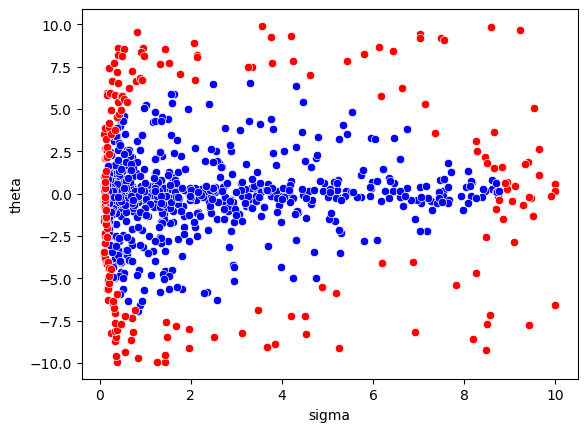

In [7]:
fig = sns.scatterplot(x='sigma', y='theta', data=training_df, c = 'b')
fig = sns.scatterplot(ax = fig, x='sigma', y='theta', data=test_df, c = 'r')

use the noise_level parameter to add artificial random normal noise

`y_hat = y + np.random.normal(0,np.std(y)*np.sqrt(noise_level), ... )`

<Axes: xlabel='sigma', ylabel='theta'>

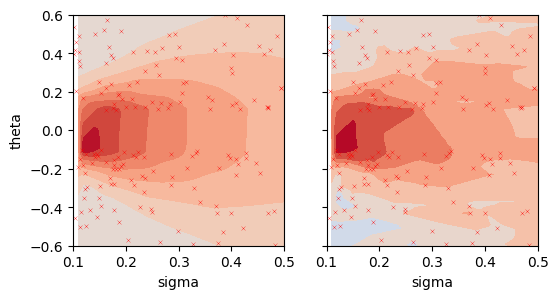

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import SCR_Benchmarks.SRSDFeynman as srsdf
from SCR_Benchmarks import SCRBenchmark

from scipy.interpolate import griddata
import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1,2, figsize=(6,3),  sharey=True)

#--------------------- plot a linear approximated contour plot -------------------------
# the benchmarks are sampled from a log10 based distribution of values skewed toward 
# their minimum value. The contourf plot however requries an equidistant grid of values.
# We generate this grid and use linear approximation to estimate a value for y at the 
# given grid coordinates. This allows us to plot a contour plot for sampled data.

def PlotContour(zi, x, y, axis):
  # sigma in [0.1,10] and theta in [-10,0.1]u[0.1,10]
  # is the actual range generated by the FeynmanICh6Eq20 benchmark
  grid_x, grid_y = np.mgrid[0.1:10:1000j, -10:10:1000j]
  grid_z0 = griddata((x,y), zi, (grid_x, grid_y), method='linear')

  norm = Normalize( vmin=-np.max(zi), vmax=np.max(zi))
  cmap = cm.get_cmap('coolwarm')
  axis.contourf(grid_x, grid_y, grid_z0, cmap= cmap , norm= norm)
  #only print a subset of the space sigma x theta \in [0.1,10]x[-10,10]
  #to increase the resolution of the interesting interaction
  axis.set_xlim([0.1,0.5])
  axis.set_ylim([-0.6,0.6])
  

# --------------------- plot benchmark instance without noise ---------------------
ICh6Eq20 = SCRBenchmark(srsdf.FeynmanICh6Eq20)

np.random.seed(0) #consider removal in production use
(training, test) = ICh6Eq20.create_dataframe(sample_size=1000, patience= 10, train_test_split = 0.8)
full = pd.concat([training, test])

PlotContour(full['f'],full['sigma'],full['theta'],ax[0])
sns.scatterplot(ax = ax[0], x=training['sigma'], y=training['theta'], c = 'b', s = 8,  marker='x')
sns.scatterplot(ax = ax[0], x=test['sigma'], y=test['theta'], c = 'r', s = 8,  marker='x')
# --------------------- plot benchmark instance with noise ---------------------
ICh6Eq20 = SCRBenchmark(srsdf.FeynmanICh6Eq20)

np.random.seed(0) #consider removal in production use
(training, test) = ICh6Eq20.create_dataframe(sample_size=1000, patience= 10, train_test_split = 0.8, noise_level= 0.2)
full = pd.concat([training, test])

PlotContour(full['f'],full['sigma'],full['theta'],ax[1])
sns.scatterplot(ax = ax[1], x=training['sigma'], y=training['theta'], c = 'b', s = 8,  marker='x')
sns.scatterplot(ax = ax[1], x=test['sigma'], y=test['theta'], c = 'r', s = 8,  marker='x')